# **Predicción de precios de casas**

## **Problema**
Pídale a un comprador de vivienda que describa la casa de sus sueños, y probablemente no comenzaráconlaalturadeltechodelsótanoola proximidadaunferrocarrileste-oeste.Peroel conjunto de datos de esta competencia en el patio de recreo demuestra que influye mucho más en las negociaciones de precios que la cantidad de dormitorios o una valla blanca.

Con 79 variables explicativas que describen (casi) todos los aspectos de las casas residenciales en Ames, Iowa, esta competencia lo desafía a predecir el precio final de cada casa.

## **Objetivo**
Obtener Precios de Casas usando métodos de Boosting Regresión
## **Métrica**
La métrica usada será RMSE

### Importando librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

### Leyendo los archivos csv de train y test

In [2]:
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')

### Seleccionando columnas que tienen mayores celdas vacías para eliminarlas de los datos de train y test

In [3]:
drop_columns = train.isnull().sum()[train.isnull().sum() > train.shape[0]/2]
drop_columns = drop_columns.index.to_list()

In [4]:
train_new = train.drop(drop_columns, axis =1)
test_new = test.drop(drop_columns, axis=1)

In [5]:
train_new.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

<Figure size 1440x720 with 0 Axes>

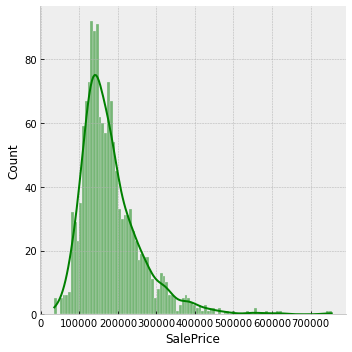

In [6]:
plt.figure(figsize=(20,10))
sns.displot(data=train_new, x='SalePrice', color='g', bins=100, kde=True)
plt.show()

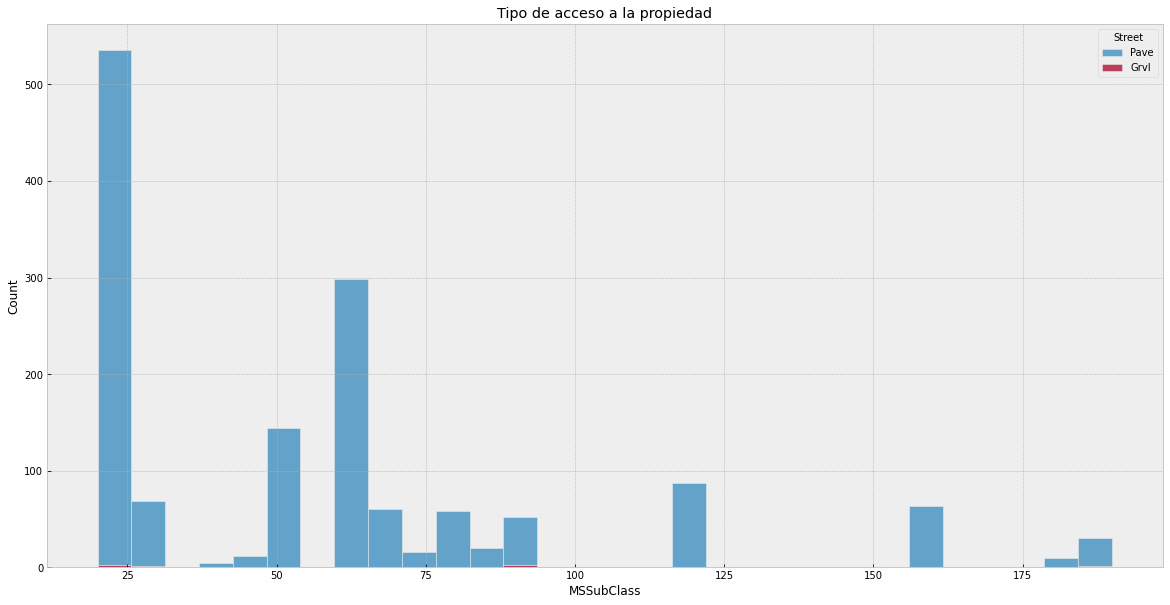

In [7]:
plt.figure(figsize=(20,10))
sns.histplot(data=train_new, x='MSSubClass', hue='Street', bins=30, multiple='stack')
plt.title('Tipo de acceso a la propiedad')
plt.show()

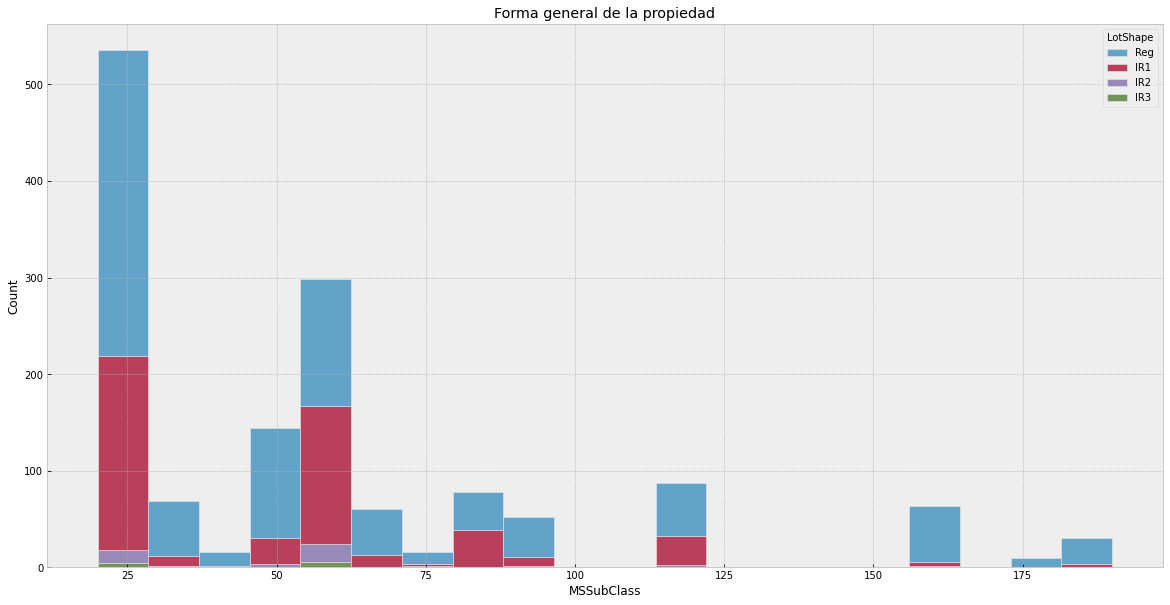

In [8]:
plt.figure(figsize=(20,10))
sns.histplot(data=train_new, x='MSSubClass', hue='LotShape', multiple='stack')
plt.title('Forma general de la propiedad')
plt.show()

In [9]:
train_new['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

### Seleccionando columnas según su tipo de variable

In [10]:
categoricos = test_new.select_dtypes(include='object').columns.to_list()
numericos = test_new.select_dtypes(exclude='object').columns.to_list()
numericos.remove('Id')
target = train_new.columns.to_list()[-1]

### Preprocesando la data

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=True, handle_unknown='ignore')
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, columns=self._columns, index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [14]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('robust_scaler', RobustScaler())
])

In [24]:
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('encoder', OneHotEncoder(sparse=True, handle_unknown='ignore')),
    ('encoder', CustomOneHotEncoder())
])

In [16]:
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_atri = list(X.select_dtypes(exclude=['object']))
        cat_atri = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
            ('num', num_pipe, num_atri),
            ('cat', cat_pipe, cat_atri),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform (self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, columns=self._columns, index=X_copy.index)

In [17]:
num_atri = list(train_new.select_dtypes(exclude=['object']))
num_atri.remove('Id')
num_atri.remove('SalePrice')

In [18]:
cat_atri = list(train_new.select_dtypes(include=['object']))

In [19]:
full_prep = ColumnTransformer([
    ('num', num_pipe, num_atri),
    ('cat', cat_pipe, cat_atri),
])

In [20]:
full_prep

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtFullBath', 'BsmtHalfB...
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Ext

In [21]:
X = train_new[num_atri + cat_atri]
y = train_new[target]

In [22]:
full_prep = ColumnTransformer([
    
])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,WD,Normal


### Modelando

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
complete_pipe = Pipeline([
    ('prep', full_prep),
    ('model', rf)
])

In [ ]:
complete_pipe

In [ ]:
complete_pipe.fit(X,y)

In [ ]:
import shap

In [ ]:
X.shape